Train Accuracy: 9.07%
Test Accuracy: 9.32%
Epoch [2/100], Loss: 5.4046
Train Accuracy: 62.43%
Test Accuracy: 61.62%


<Figure size 640x480 with 0 Axes>

<Figure size 1920x1440 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1920x1440 with 0 Axes>

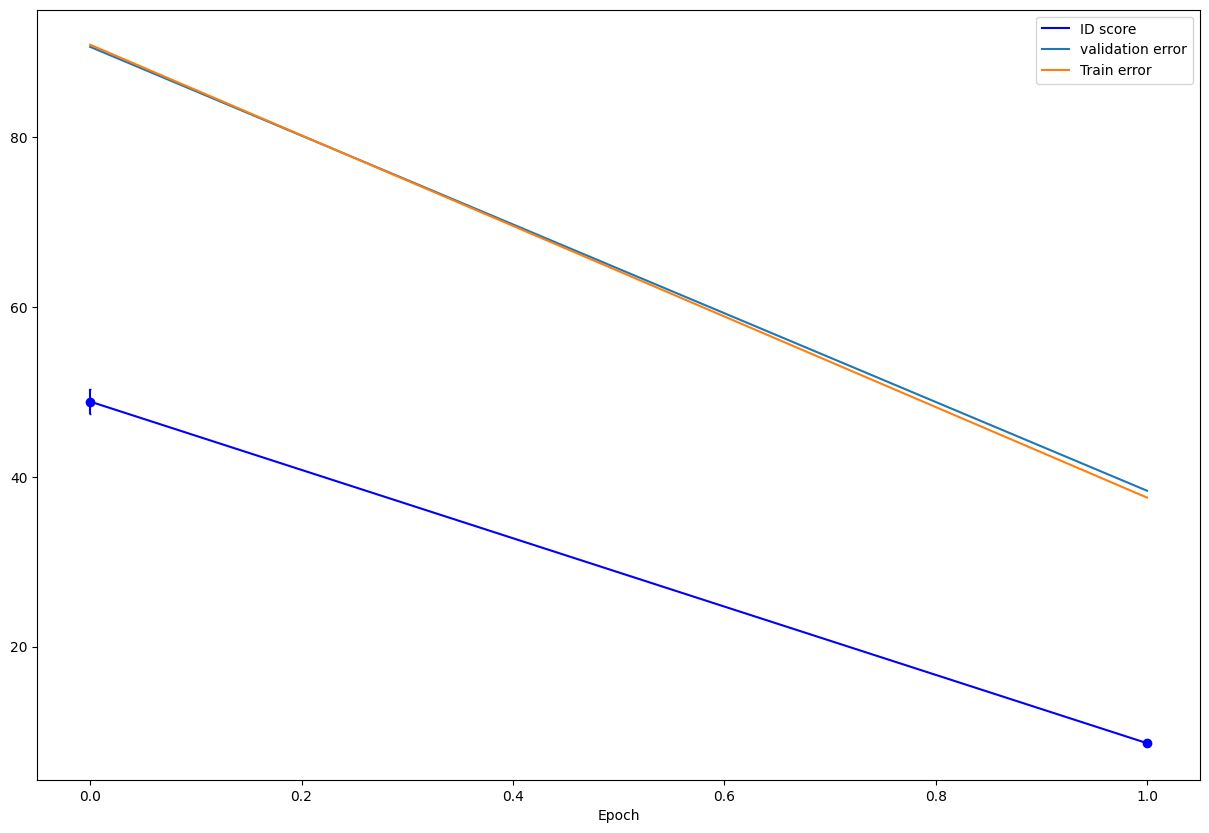

Epoch [3/100], Loss: 4.2072
Train Accuracy: 68.46%
Test Accuracy: 68.58%


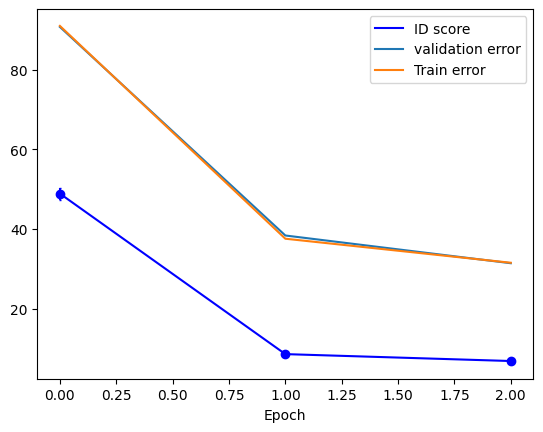

Epoch [4/100], Loss: 3.8168
Train Accuracy: 70.19%
Test Accuracy: 69.86%


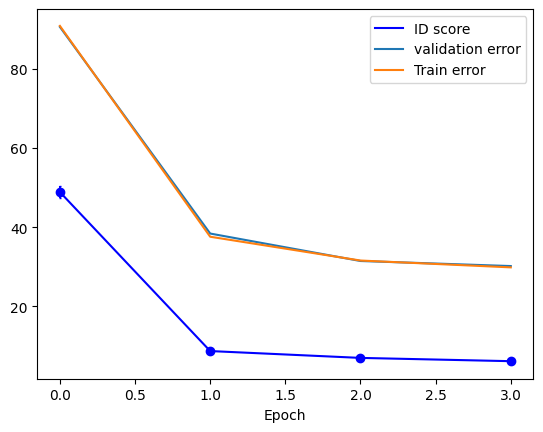

Epoch [5/100], Loss: 3.6743
Train Accuracy: 70.84%
Test Accuracy: 70.95%


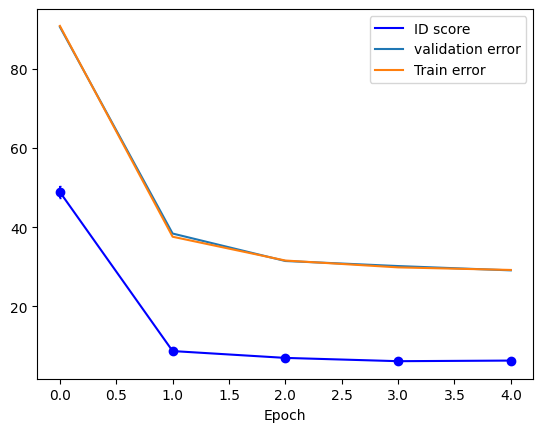

Epoch [6/100], Loss: 3.5654
Train Accuracy: 73.44%
Test Accuracy: 72.58%


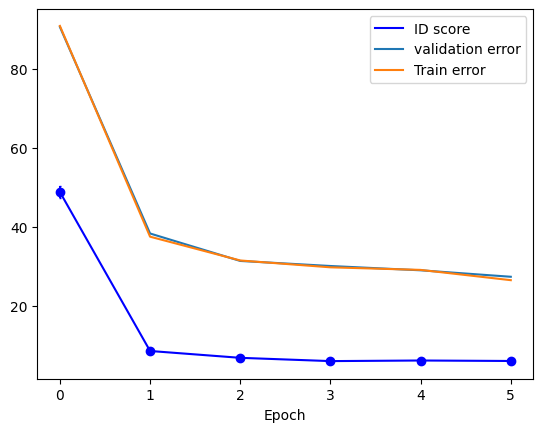

Epoch [7/100], Loss: 3.4330
Train Accuracy: 72.65%
Test Accuracy: 70.91%


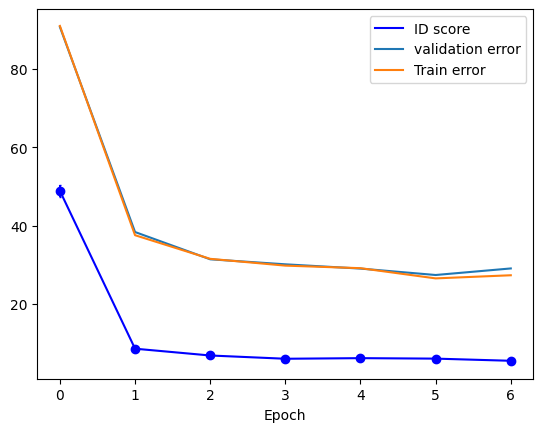

Epoch [8/100], Loss: 3.3312
Train Accuracy: 71.93%
Test Accuracy: 70.40%


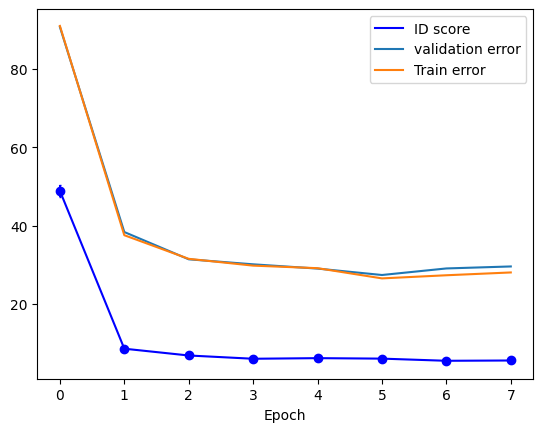

Epoch [9/100], Loss: 3.3187
Train Accuracy: 75.12%
Test Accuracy: 74.12%


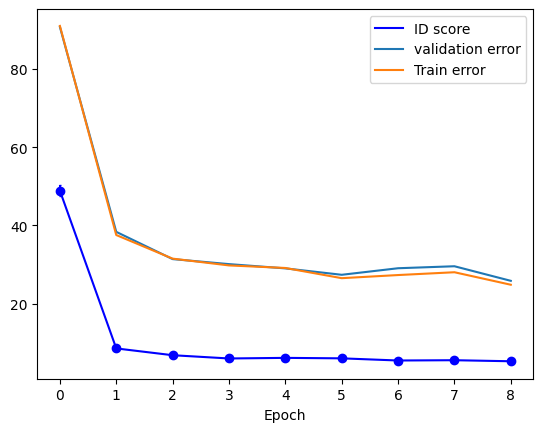

Epoch [10/100], Loss: 3.1963
Train Accuracy: 76.44%
Test Accuracy: 75.40%


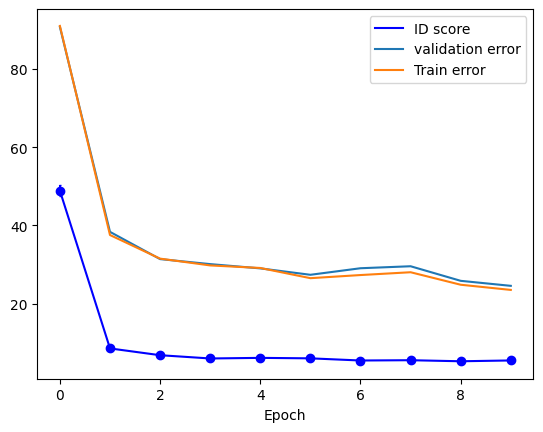

Epoch [11/100], Loss: 3.1358
Train Accuracy: 75.60%
Test Accuracy: 74.18%


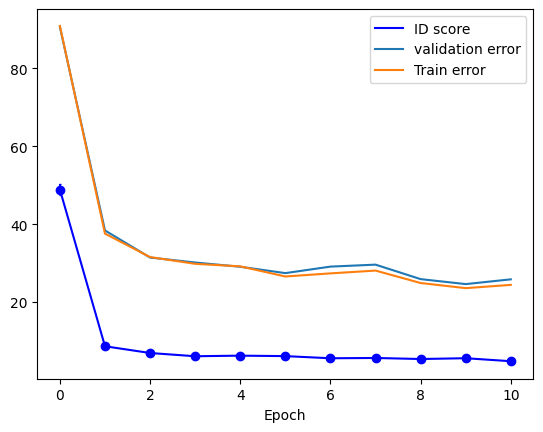

Epoch [12/100], Loss: 3.0789
Train Accuracy: 76.40%
Test Accuracy: 74.10%


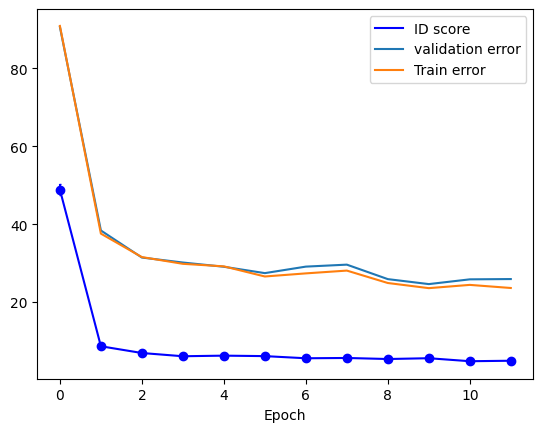

Epoch [13/100], Loss: 3.0125
Train Accuracy: 77.19%
Test Accuracy: 74.89%


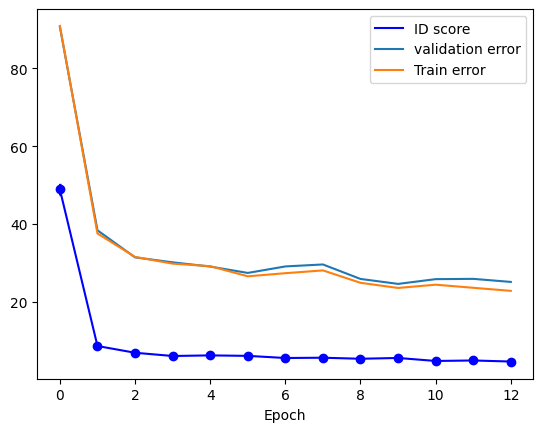

Epoch [14/100], Loss: 3.0207
Train Accuracy: 73.95%
Test Accuracy: 72.20%


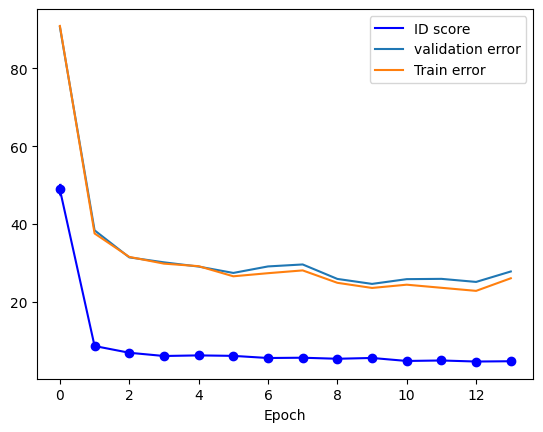

Epoch [15/100], Loss: 2.9722
Train Accuracy: 78.95%
Test Accuracy: 76.32%


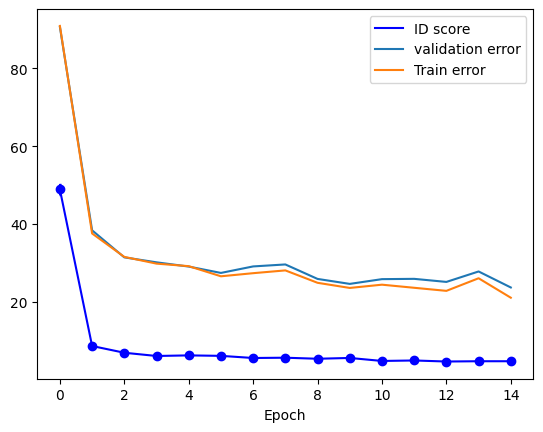

Epoch [16/100], Loss: 2.8800
Train Accuracy: 77.60%
Test Accuracy: 75.04%


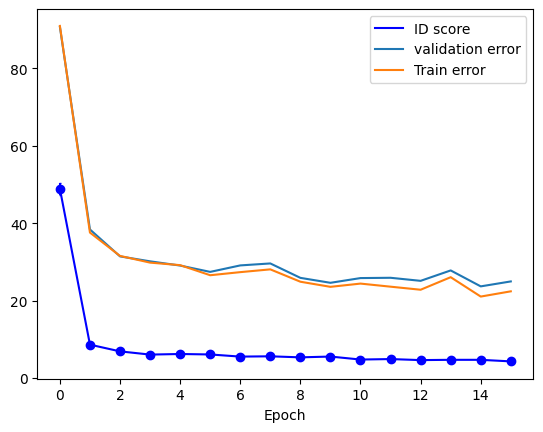

Epoch [17/100], Loss: 2.8389
Train Accuracy: 78.03%
Test Accuracy: 76.13%


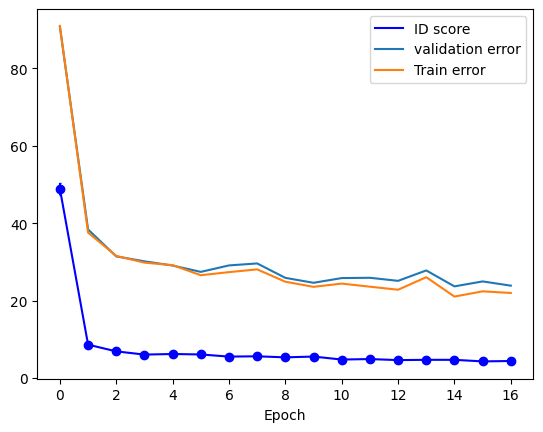

Epoch [18/100], Loss: 2.8520
Train Accuracy: 77.19%
Test Accuracy: 74.74%


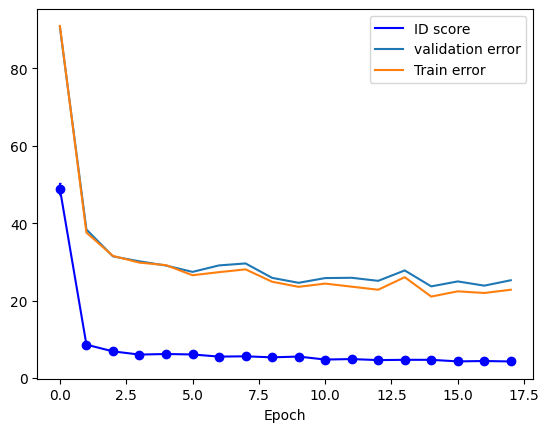

Epoch [19/100], Loss: 2.7608
Train Accuracy: 78.75%
Test Accuracy: 76.30%


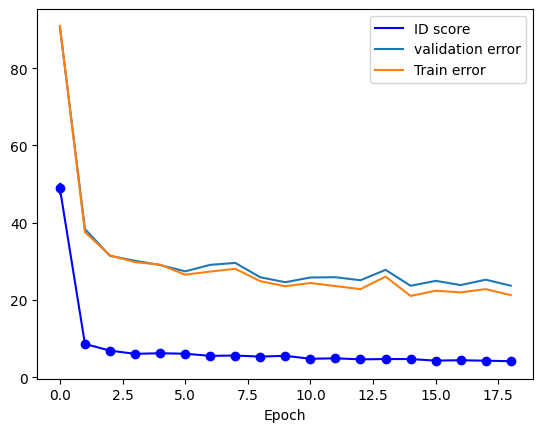

Epoch [20/100], Loss: 2.7853
Train Accuracy: 79.84%
Test Accuracy: 77.15%


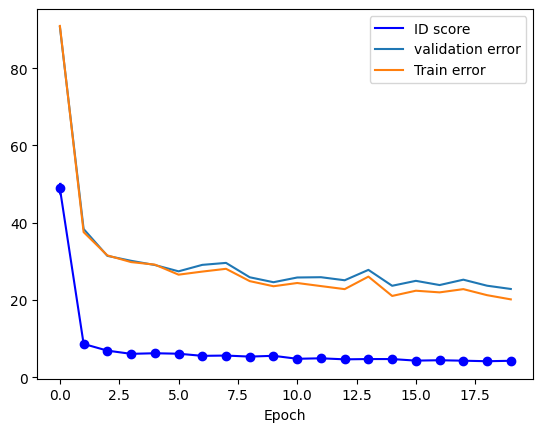

Epoch [21/100], Loss: 2.6912
Train Accuracy: 79.47%
Test Accuracy: 76.96%


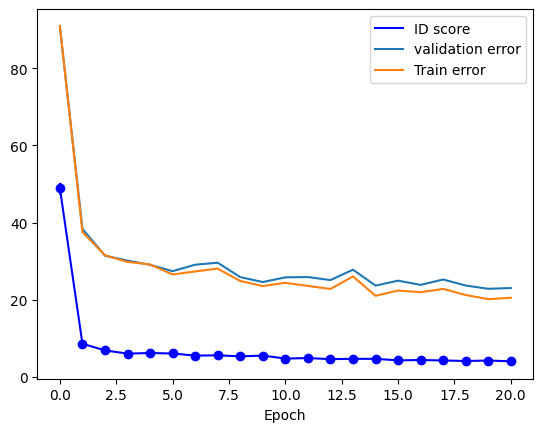

Epoch [22/100], Loss: 2.7107
Train Accuracy: 79.78%
Test Accuracy: 77.24%


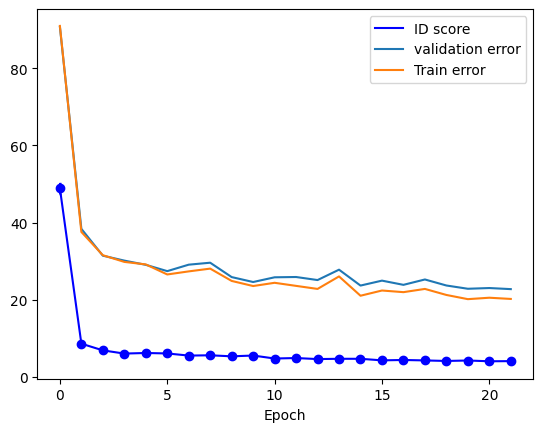

Epoch [23/100], Loss: 2.6668
Train Accuracy: 79.90%
Test Accuracy: 76.32%


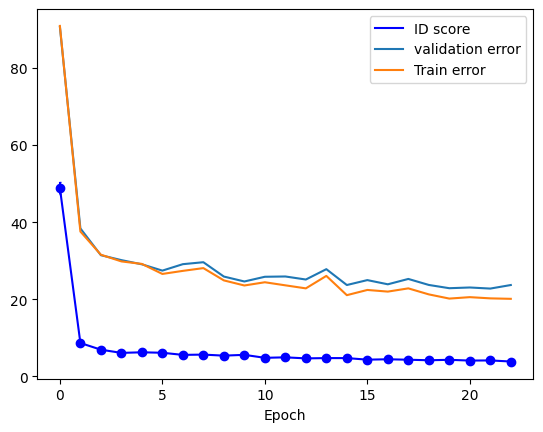

Epoch [24/100], Loss: 2.6557
Train Accuracy: 79.07%
Test Accuracy: 76.19%


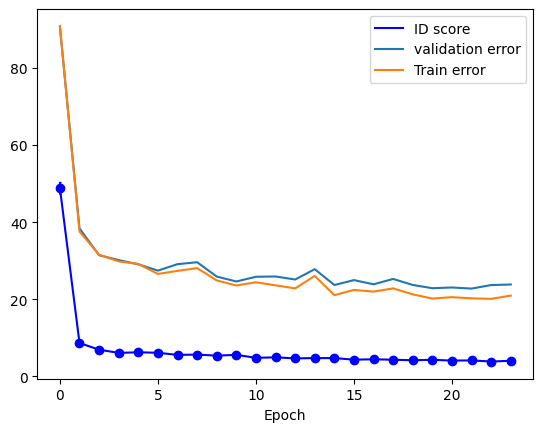

Epoch [25/100], Loss: 2.6215
Train Accuracy: 80.34%
Test Accuracy: 76.49%


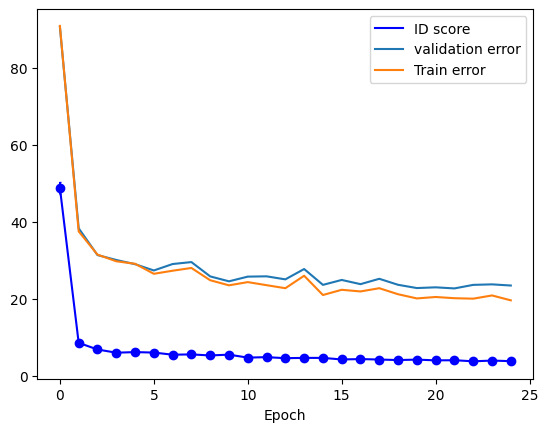

Epoch [26/100], Loss: 2.6083
Train Accuracy: 79.50%
Test Accuracy: 76.56%


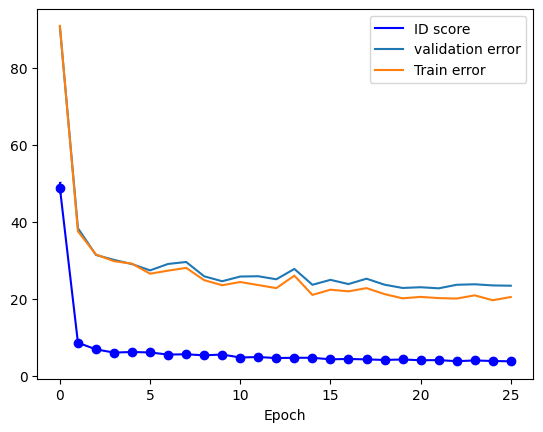

Epoch [27/100], Loss: 2.5766
Train Accuracy: 79.48%
Test Accuracy: 75.49%


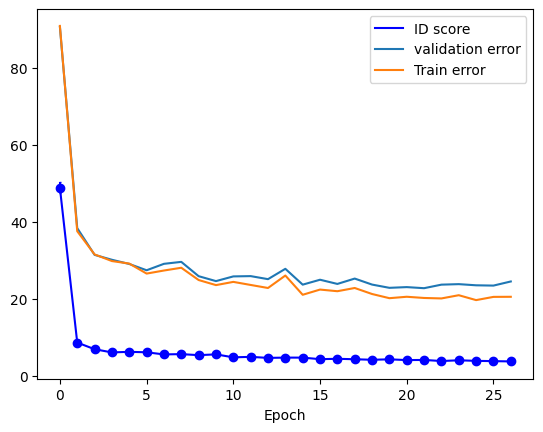

Epoch [28/100], Loss: 2.5536
Train Accuracy: 80.66%
Test Accuracy: 76.55%


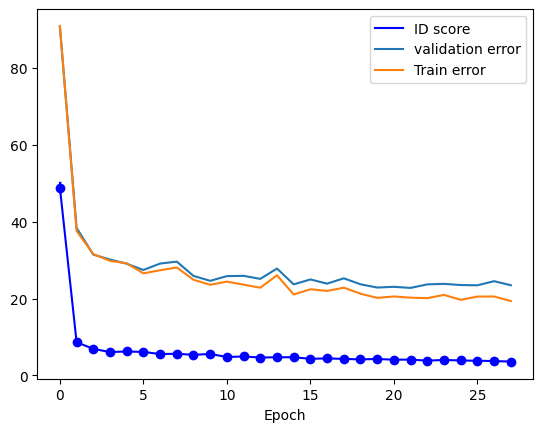

Epoch [29/100], Loss: 2.5331
Train Accuracy: 80.15%
Test Accuracy: 75.76%


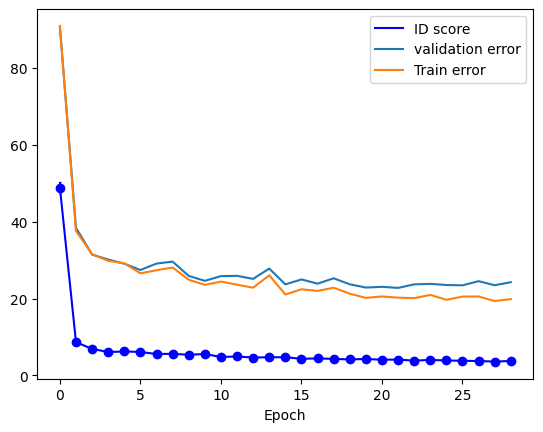

Epoch [30/100], Loss: 2.5334
Train Accuracy: 81.31%
Test Accuracy: 77.82%


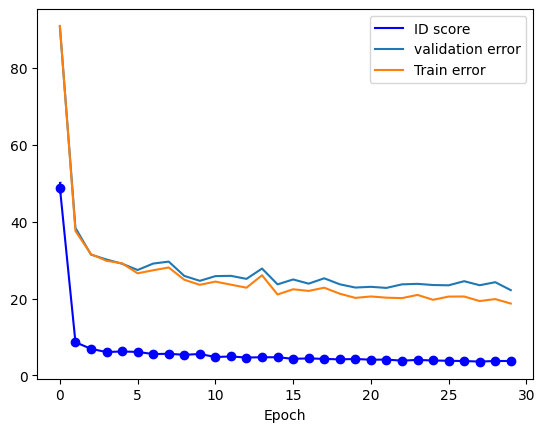

Epoch [31/100], Loss: 2.5280
Train Accuracy: 82.19%
Test Accuracy: 77.47%


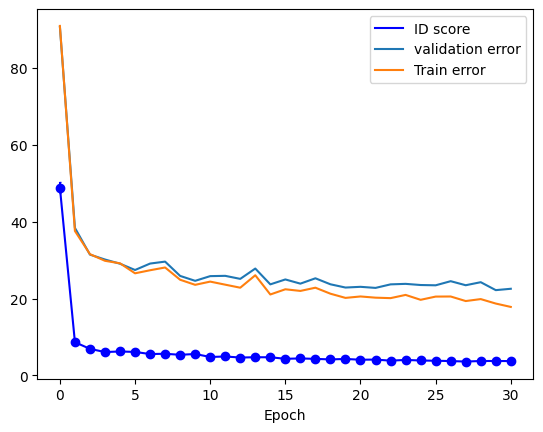

Epoch [32/100], Loss: 2.4970
Train Accuracy: 82.00%
Test Accuracy: 77.82%


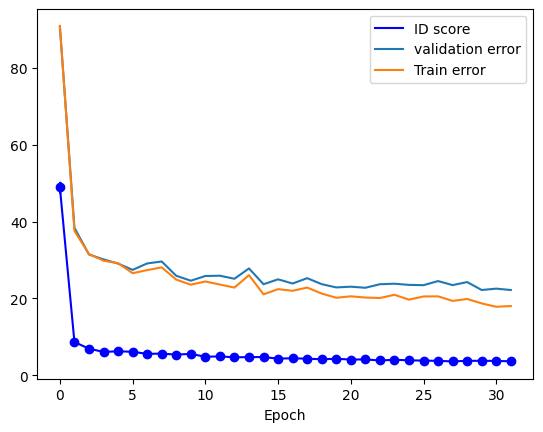

Epoch [33/100], Loss: 2.4762
Train Accuracy: 82.35%
Test Accuracy: 77.75%


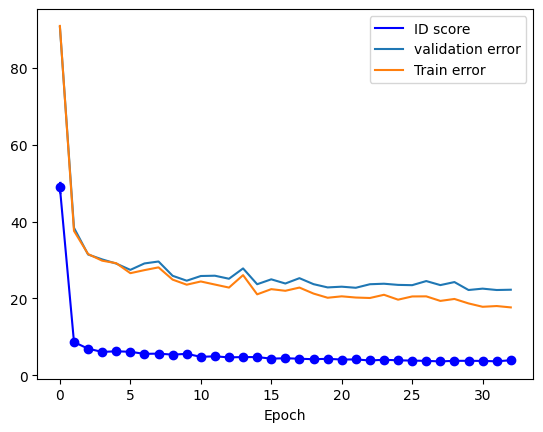

Epoch [34/100], Loss: 2.4444
Train Accuracy: 81.89%
Test Accuracy: 76.68%


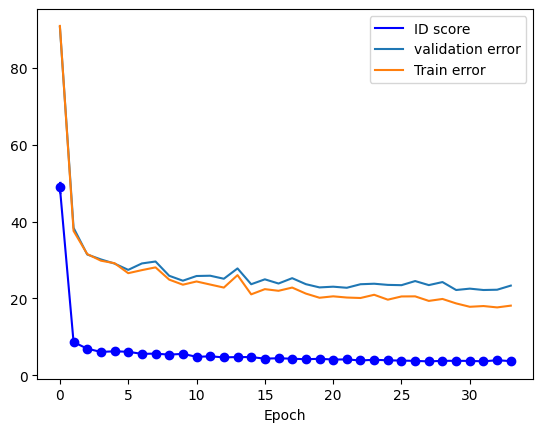

Epoch [35/100], Loss: 2.4265
Train Accuracy: 82.00%
Test Accuracy: 76.56%


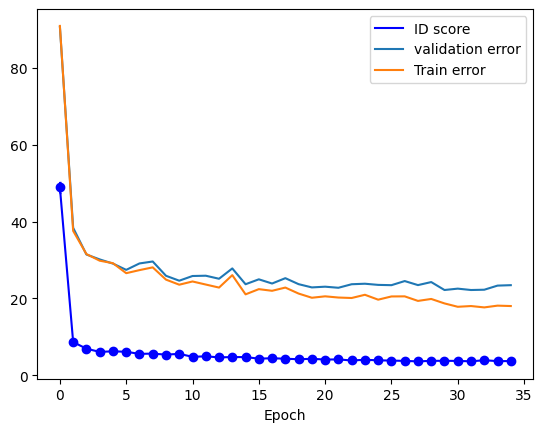

Epoch [36/100], Loss: 2.3786
Train Accuracy: 82.44%
Test Accuracy: 76.92%


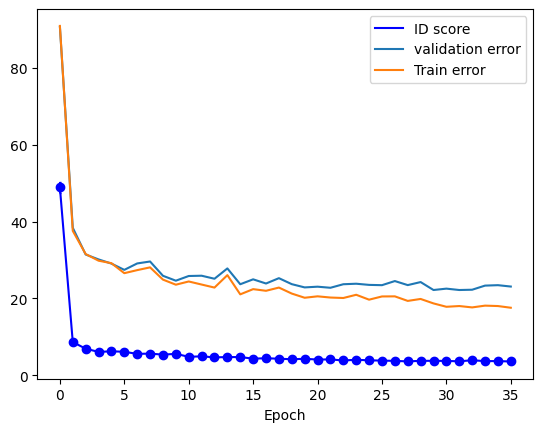

Epoch [37/100], Loss: 2.3675
Train Accuracy: 83.17%
Test Accuracy: 77.75%


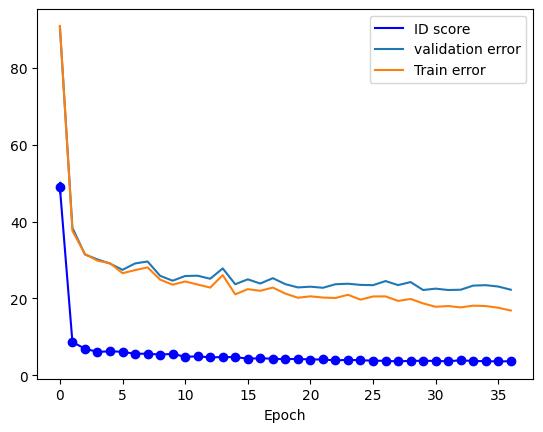

Epoch [38/100], Loss: 2.3888
Train Accuracy: 83.61%
Test Accuracy: 77.35%


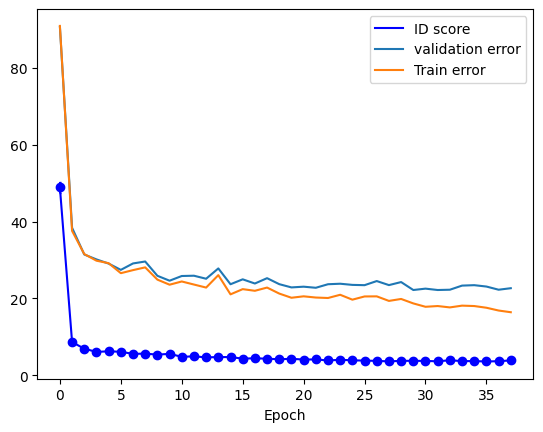

Epoch [39/100], Loss: 2.4197
Train Accuracy: 83.36%
Test Accuracy: 76.64%


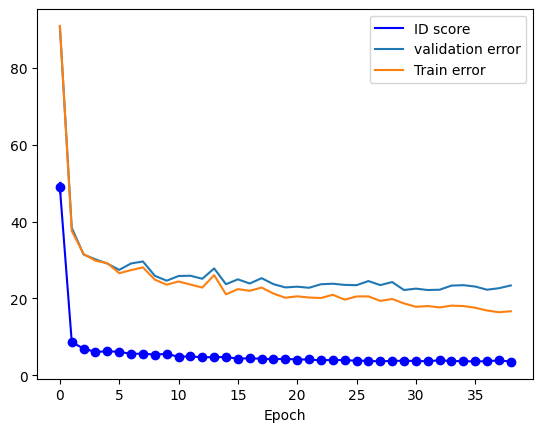

Epoch [40/100], Loss: 2.4329
Train Accuracy: 82.91%
Test Accuracy: 77.18%


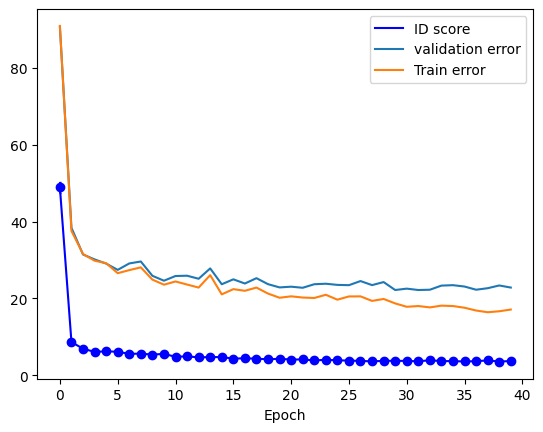

Epoch [41/100], Loss: 2.3346
Train Accuracy: 83.55%
Test Accuracy: 77.26%


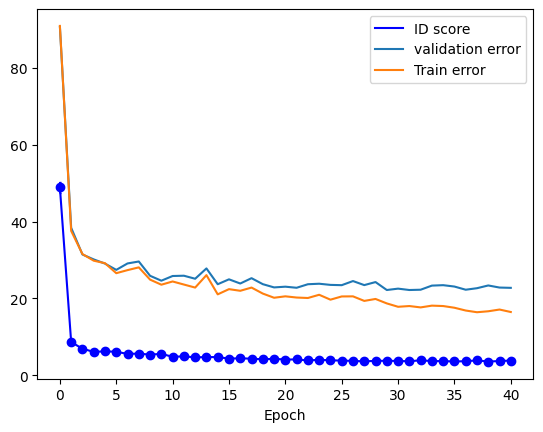

Epoch [42/100], Loss: 2.3649
Train Accuracy: 83.66%
Test Accuracy: 77.52%


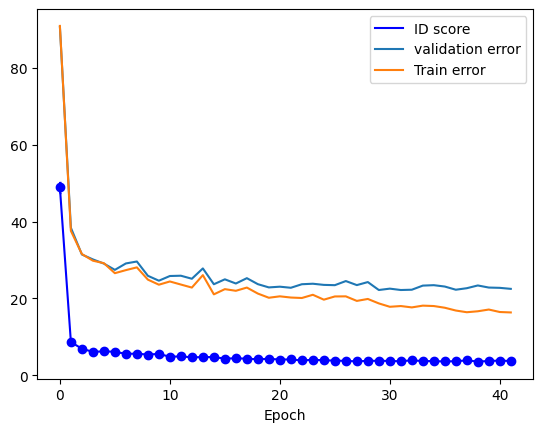

Epoch [43/100], Loss: 2.3424
Train Accuracy: 84.21%
Test Accuracy: 77.09%


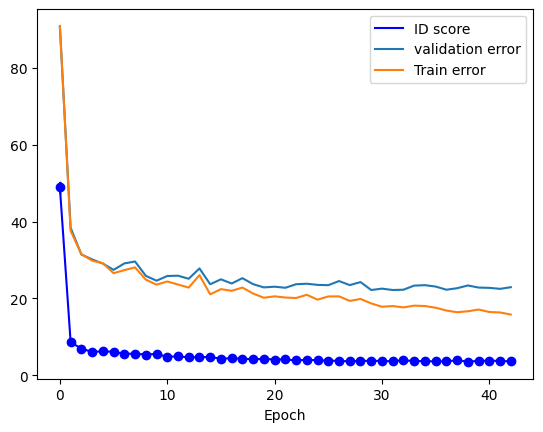

Epoch [44/100], Loss: 2.3391
Train Accuracy: 84.24%
Test Accuracy: 77.05%


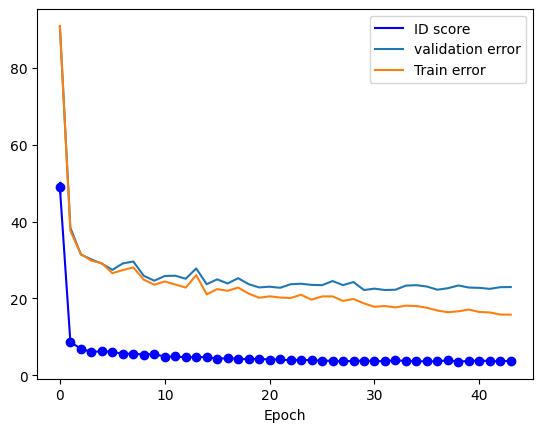

Epoch [45/100], Loss: 2.3008
Train Accuracy: 85.25%
Test Accuracy: 77.24%


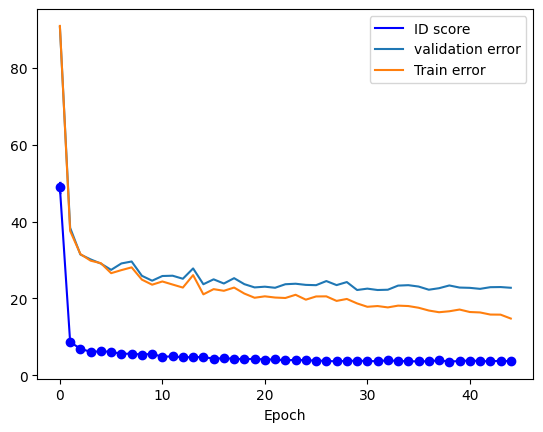

Epoch [46/100], Loss: 2.3138
Train Accuracy: 84.46%
Test Accuracy: 76.34%


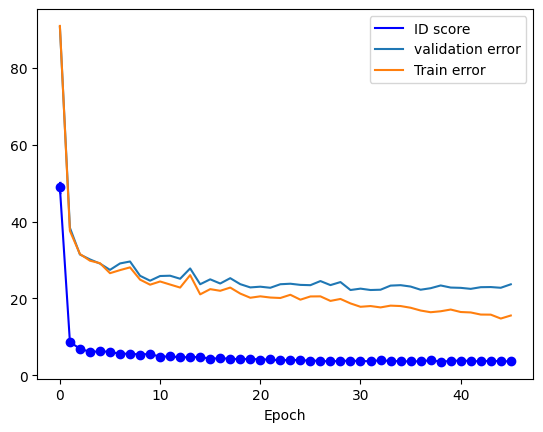

Epoch [47/100], Loss: 2.2459
Train Accuracy: 85.14%
Test Accuracy: 77.69%


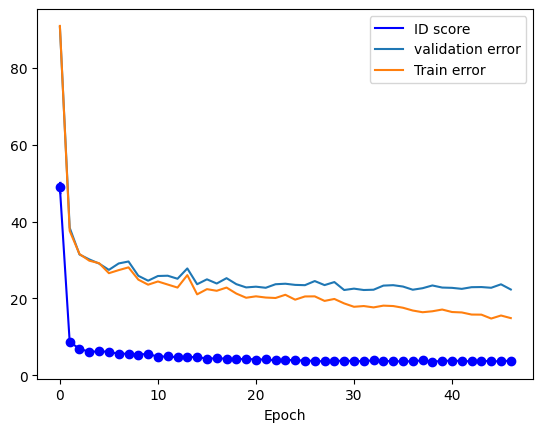

Epoch [48/100], Loss: 2.3312
Train Accuracy: 85.65%
Test Accuracy: 77.67%


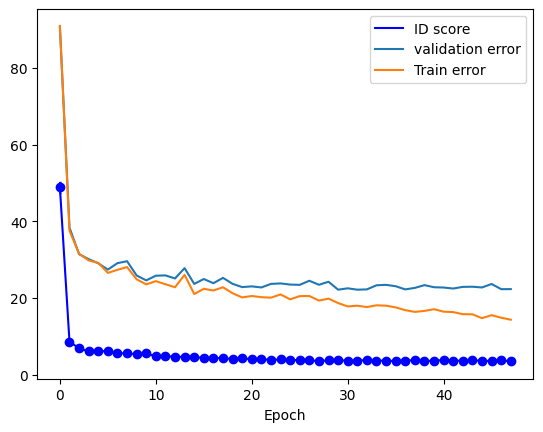

Epoch [49/100], Loss: 2.2722
Train Accuracy: 85.59%
Test Accuracy: 77.94%


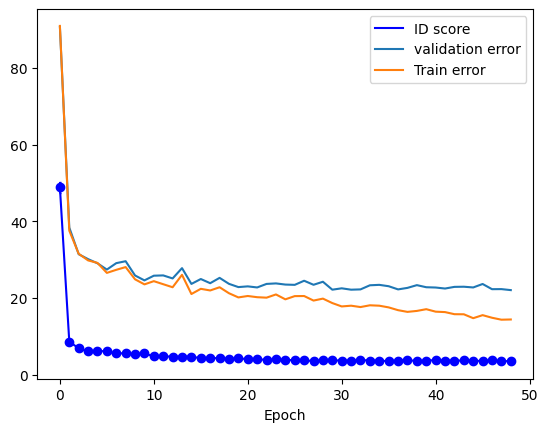

Epoch [50/100], Loss: 2.2080
Train Accuracy: 84.87%
Test Accuracy: 76.77%


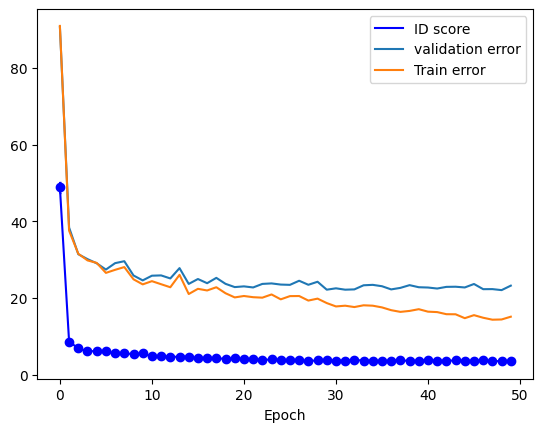

Epoch [51/100], Loss: 2.2407
Train Accuracy: 86.15%
Test Accuracy: 76.26%


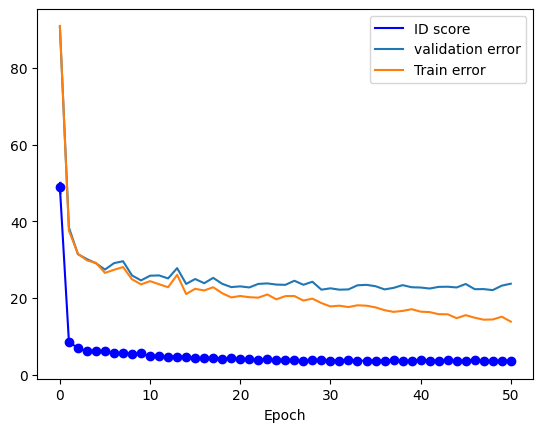

Epoch [52/100], Loss: 2.2159
Train Accuracy: 85.90%
Test Accuracy: 76.75%


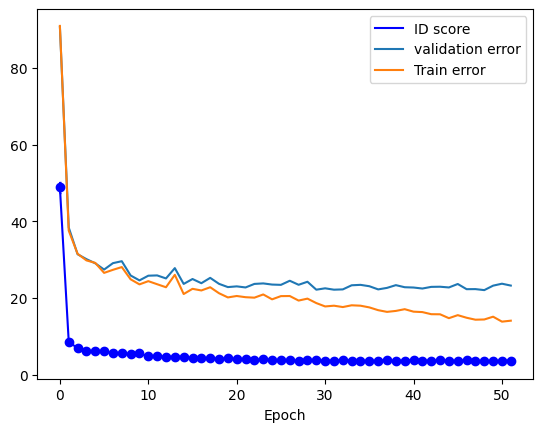

Epoch [53/100], Loss: 2.2282
Train Accuracy: 86.18%
Test Accuracy: 76.32%


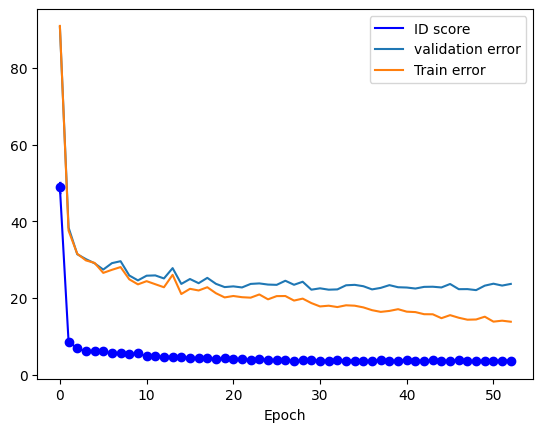

Epoch [54/100], Loss: 2.2113
Train Accuracy: 85.86%
Test Accuracy: 76.43%


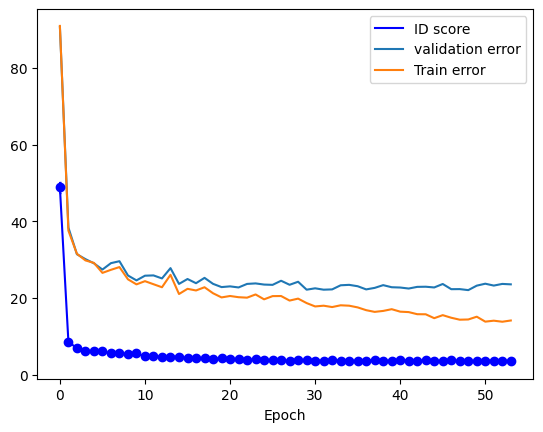

Epoch [55/100], Loss: 2.1700
Train Accuracy: 86.72%
Test Accuracy: 76.92%


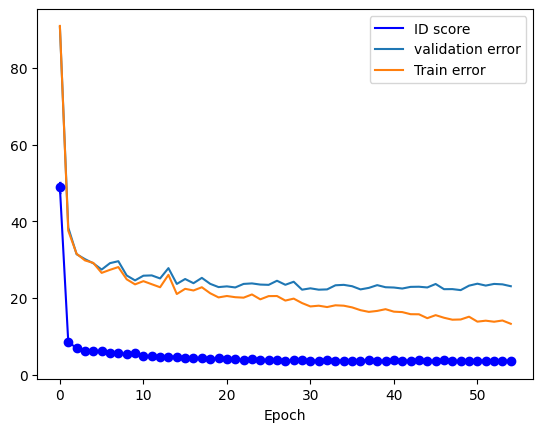

Epoch [56/100], Loss: 2.1764
Train Accuracy: 86.18%
Test Accuracy: 75.49%


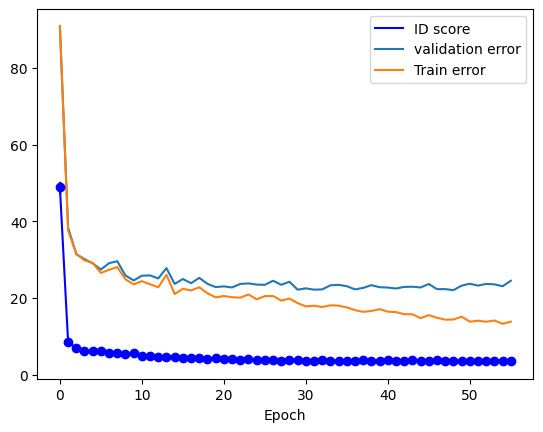

Epoch [57/100], Loss: 2.1450
Train Accuracy: 88.01%
Test Accuracy: 77.56%


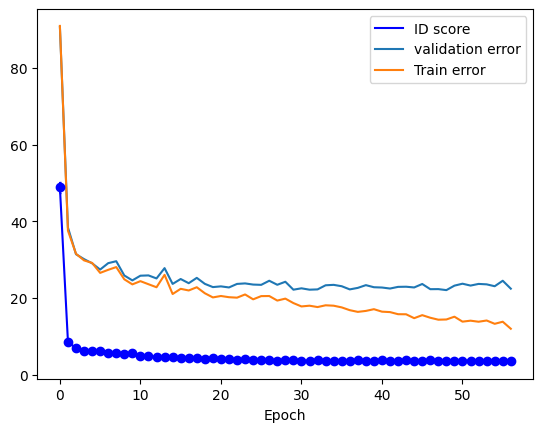

Epoch [58/100], Loss: 2.1585
Train Accuracy: 87.85%
Test Accuracy: 76.25%


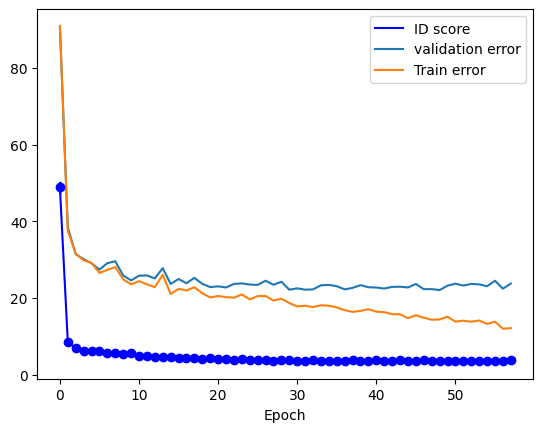

Epoch [59/100], Loss: 2.1534
Train Accuracy: 87.15%
Test Accuracy: 75.66%


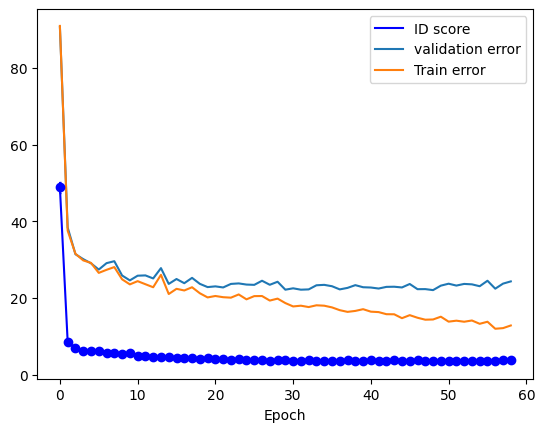

Epoch [60/100], Loss: 2.0882
Train Accuracy: 88.26%
Test Accuracy: 76.77%


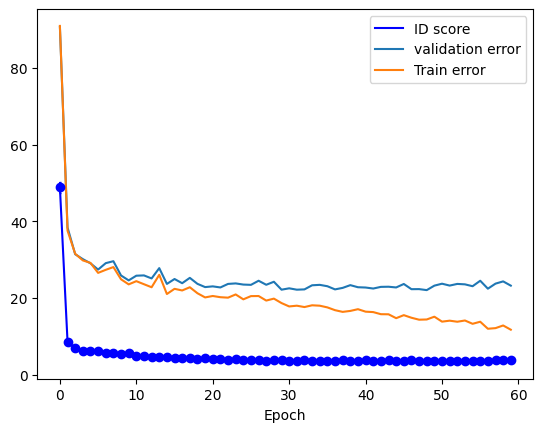

Epoch [61/100], Loss: 2.0709
Train Accuracy: 88.83%
Test Accuracy: 76.17%


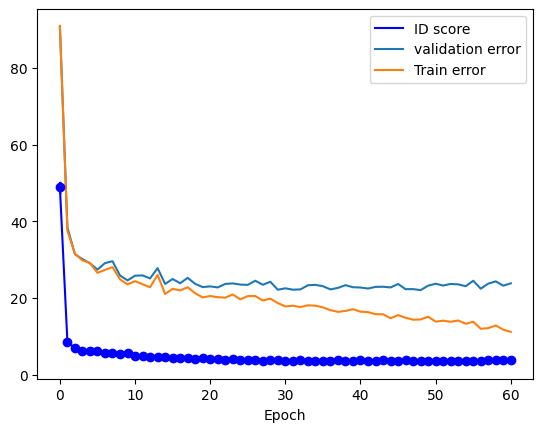

Epoch [62/100], Loss: 2.1016
Train Accuracy: 88.79%
Test Accuracy: 75.61%


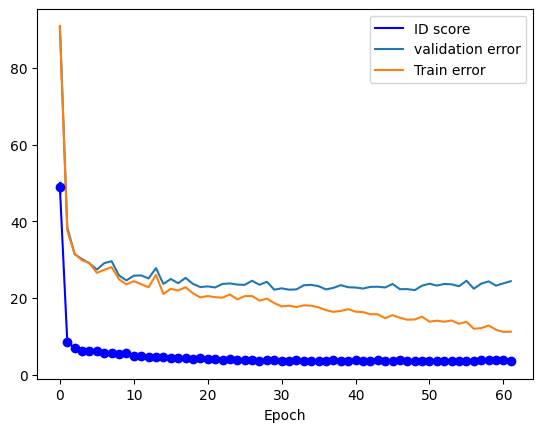

Epoch [63/100], Loss: 2.0616
Train Accuracy: 87.64%
Test Accuracy: 74.67%


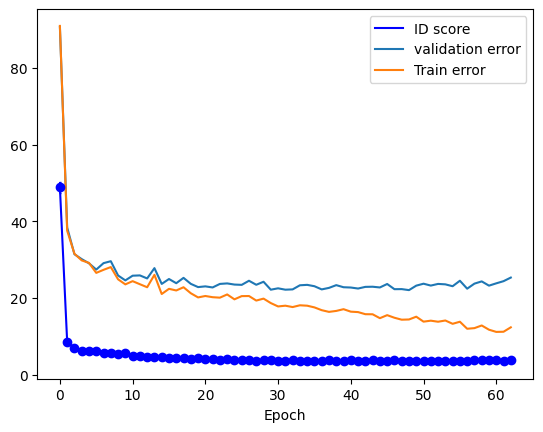

Epoch [64/100], Loss: 2.0567
Train Accuracy: 88.65%
Test Accuracy: 74.65%


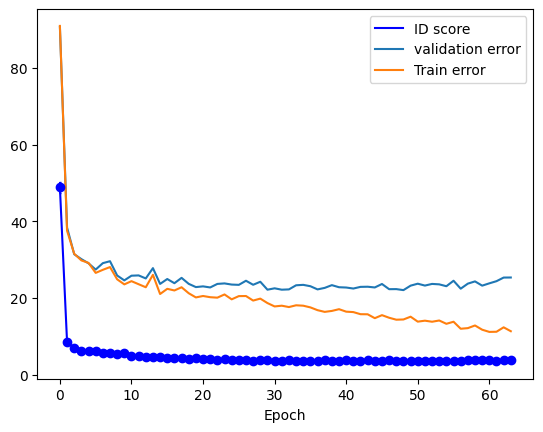

Epoch [65/100], Loss: 2.0038
Train Accuracy: 89.46%
Test Accuracy: 76.32%


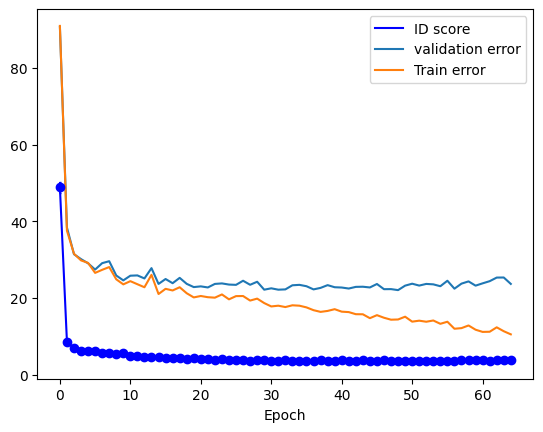

Epoch [66/100], Loss: 2.0016
Train Accuracy: 89.41%
Test Accuracy: 75.85%


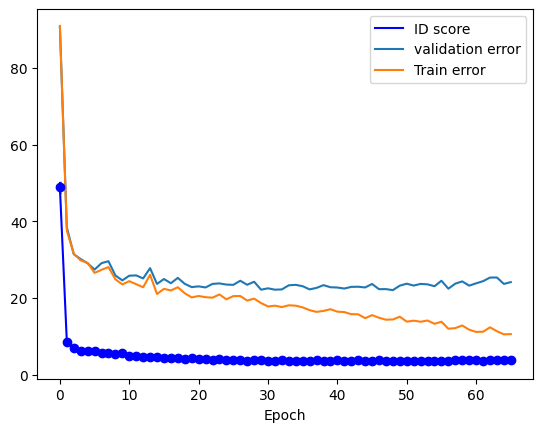

Epoch [67/100], Loss: 2.0263
Train Accuracy: 89.08%
Test Accuracy: 75.70%


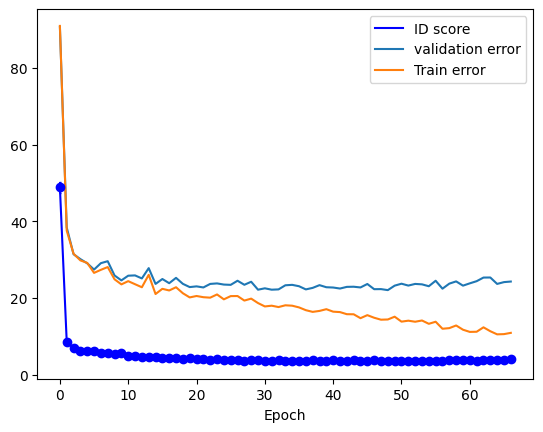

Epoch [68/100], Loss: 2.0580
Train Accuracy: 89.68%
Test Accuracy: 75.57%


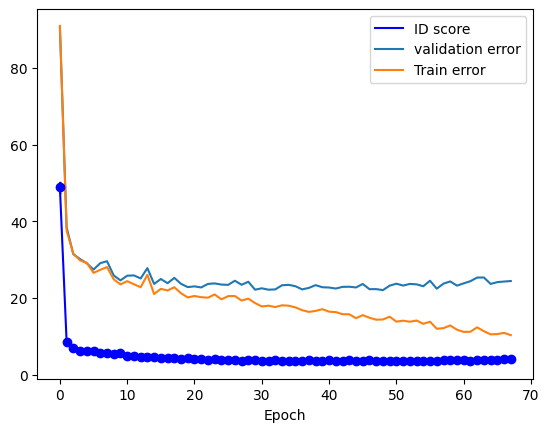

Epoch [69/100], Loss: 2.0054
Train Accuracy: 90.39%
Test Accuracy: 75.08%


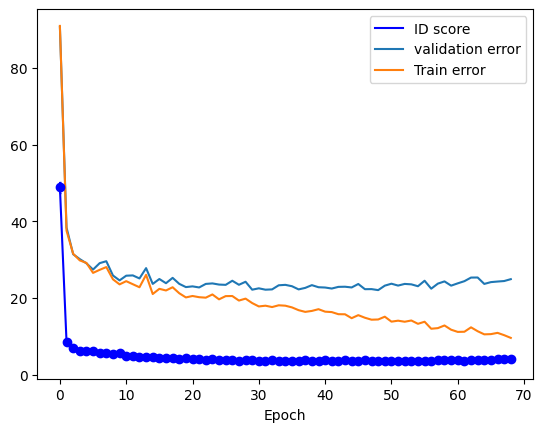

Epoch [70/100], Loss: 2.0238
Train Accuracy: 90.49%
Test Accuracy: 74.69%


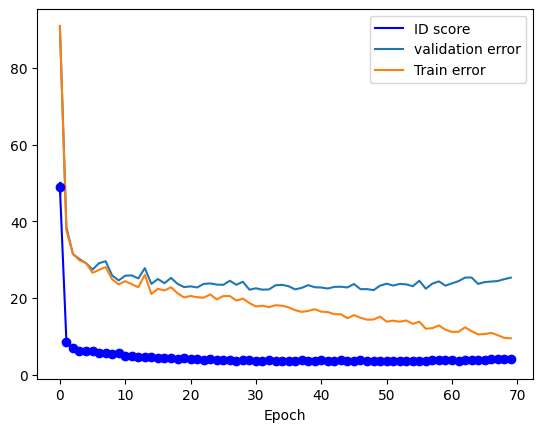

Epoch [71/100], Loss: 1.9773
Train Accuracy: 90.75%
Test Accuracy: 75.98%


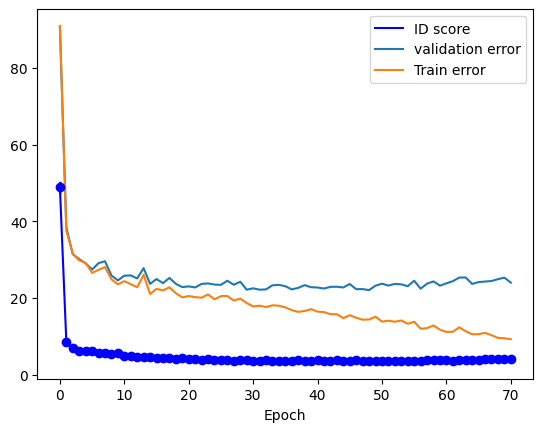

Epoch [72/100], Loss: 1.9401
Train Accuracy: 91.38%
Test Accuracy: 76.28%


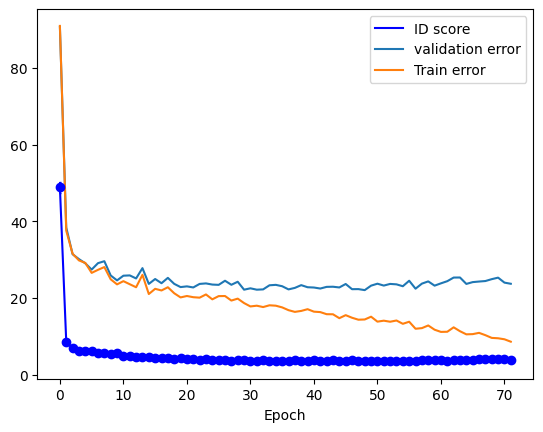

Epoch [73/100], Loss: 1.9383
Train Accuracy: 91.36%
Test Accuracy: 75.36%


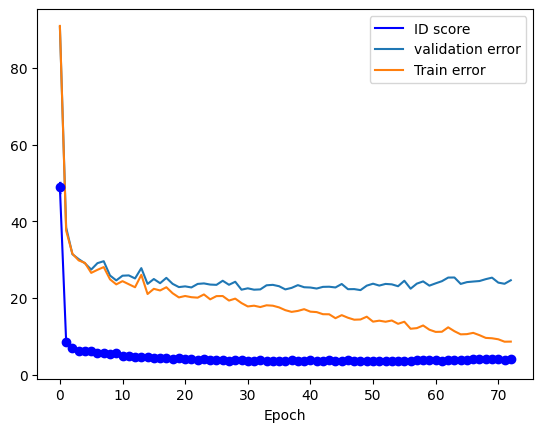

Epoch [74/100], Loss: 1.9416
Train Accuracy: 91.70%
Test Accuracy: 76.19%


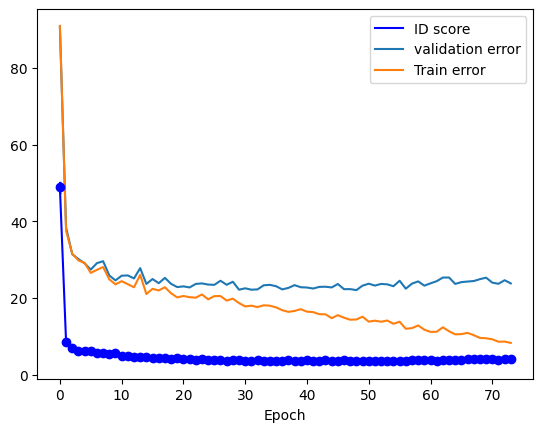

Epoch [75/100], Loss: 1.9664
Train Accuracy: 91.71%
Test Accuracy: 75.93%


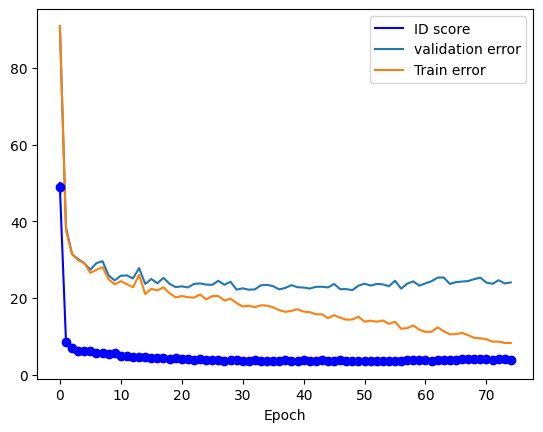

Epoch [76/100], Loss: 1.9106
Train Accuracy: 92.32%
Test Accuracy: 74.16%


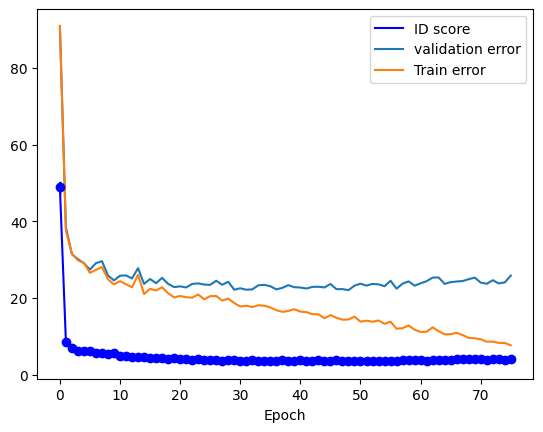

Epoch [77/100], Loss: 1.9126
Train Accuracy: 92.45%
Test Accuracy: 74.95%


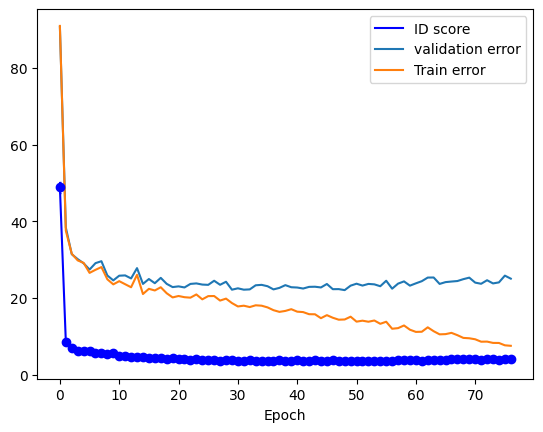

Epoch [78/100], Loss: 1.8712
Train Accuracy: 91.91%
Test Accuracy: 74.50%


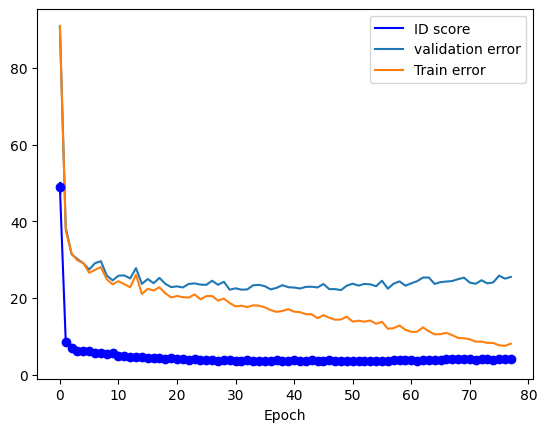

Epoch [79/100], Loss: 1.8516
Train Accuracy: 92.54%
Test Accuracy: 74.78%


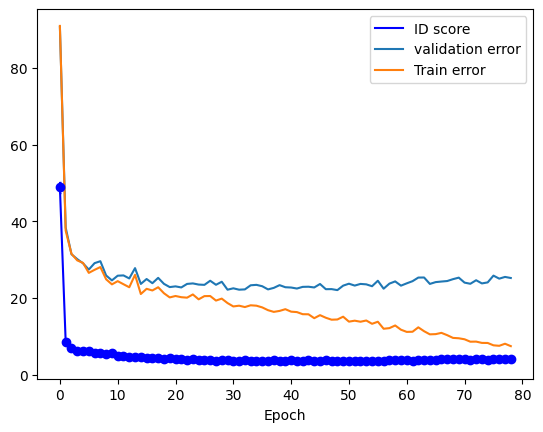

Epoch [80/100], Loss: 1.8572
Train Accuracy: 93.01%
Test Accuracy: 74.48%


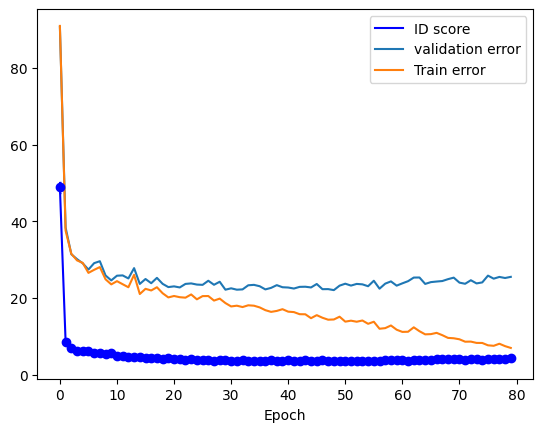

Epoch [81/100], Loss: 1.8301
Train Accuracy: 92.44%
Test Accuracy: 74.76%


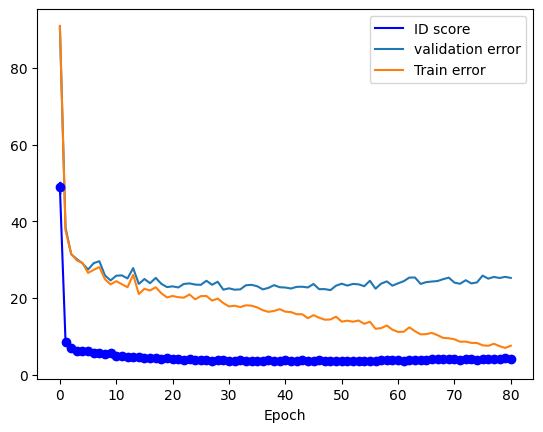

Epoch [82/100], Loss: 1.9153
Train Accuracy: 93.47%
Test Accuracy: 74.95%


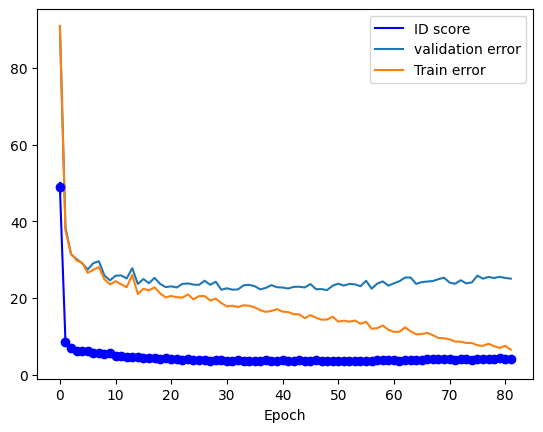

Epoch [83/100], Loss: 1.8110
Train Accuracy: 94.06%
Test Accuracy: 75.08%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import backbone.Custom as cust
import backbone.VISUAL as viz
import importlib
import matplotlib.pyplot as plt
import backbone.AstroMLmod as AstroMLmod
import numpy as np
import backbone.TwoNN as TwoNN
import time
import h5py
import skdim
    
importlib.reload(cust)
importlib.reload(viz)
importlib.reload(AstroMLmod)


def get_data_loaders(Dir = "some/directory", batch_size = 32):

    #obtain  data from a folder a of images
    dataset = torchvision.datasets.ImageFolder(Dir)
    names = [name[0].split('/')[-1] for name in dataset.imgs]
    transformed_dataset = cust.Custom_labelled(dataset,names =names,resize = 256,crop = 224)


    dataset_split = cust.train_val_dataset(transformed_dataset, val_split=0.30)
    

    train_loader = torch.utils.data.DataLoader(dataset_split['train'], batch_size=batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset_split['val'], batch_size=batch_size, shuffle=True)
    
    return train_loader, test_loader

def perturb_list_by_swapping(lst, percentage=5):
    num_swaps = max(1, int(len(lst) * (percentage / 100)))  # Ensure at least one swap
    perturbed_lst = lst[:]  # Copy the list to avoid modifying the original

    for _ in range(num_swaps):
        i, j = random.sample(range(len(lst)), 2)  # Pick two distinct indices
        perturbed_lst[i], perturbed_lst[j] = perturbed_lst[j], perturbed_lst[i]  # Swap them
    
    return perturbed_lst


def galaxyzoo10(batch_size = 256):

    # To get the images and labels from file
    with h5py.File('Galaxy10_DECals.h5', 'r') as F:
        images = np.array(F['images'])
        labels = np.array(F['ans'])
        ids = np.array(F['ra'])
    
    # To convert the labels to categorical 10 classes

    # To convert to desirable type
    labels = labels.astype(np.int64)
    labels = perturb_list_by_swapping(labels, percentage=5)
    images = images.astype(np.float32)
    

    transformed_dataset = cust.ArrayDataset(images = images,labels =labels,names = ids,resize = 256,crop = 224)


    dataset_split = cust.train_val_dataset(transformed_dataset, val_split=0.30)
    

    train_loader = torch.utils.data.DataLoader(dataset_split['train'], batch_size=batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset_split['val'], batch_size=batch_size, shuffle=True)

    return train_loader, test_loader




def train_resnet(num_epochs=100, learning_rate=0.0005, Dir ="galaxy_zoo_class_new", batch_size=128, device='cuda'):

    fig = plt.figure(dpi = 300)
    plt.style.use("default")
    plt.figure(figsize=(15,10))
    plt.rcParams.update({'font.size': 20}) 


    train_loader, test_loader = galaxyzoo10(batch_size = batch_size)
    
    model = models.efficientnet_b0(weights = "IMAGENET1K_V1")

    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #get_representations(model = model,loader = train_loader, batch_size = batch_size, epoch = 0,device  = device)
    model.classifier[1]= nn.Linear(model.classifier[1].in_features, 10) 
    #randomize the weights of the newly added sub-layers
    model.classifier[1].weight.data.normal_(0,0.01)
    model = model.to(device)

    intrinsic_dimension = []
    validation_accuracy = []
    train_accuracy = []

    #Obtain train and test accuracies
    
    train, val = evaluate(model, train_loader, test_loader, device)

    #get representatations
    test_representations = cust.get_representations(model = model,loader = test_loader, batch_size = batch_size, epoch = 0,device  = device)

    #conpute the id_score
    id_score,std = AstroMLmod.id_score(test_representations)
    
    intrinsic_dimension.append((id_score,std))
    
    validation_accuracy.append(val)
    train_accuracy.append(train)
    fig = plt.figure(dpi = 300)
    plt.style.use("default")
    plt.figure(figsize=(15,10))


    
    for epoch in range(1,num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels, names in train_loader:
            
            
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
        model.eval()
        
        train, val = evaluate(model, train_loader, test_loader, device)
        #save classification layer for next epoch
        
        class_layer = model.classifier
        
        test_representations = cust.get_representations(model = model,loader = test_loader, batch_size = batch_size, epoch = 0,device  = device)

        #conpute the id_score
        id_score,std = AstroMLmod.id_score(test_representations)
    
        intrinsic_dimension.append((id_score,std))
        y, yerr = zip(*intrinsic_dimension)


        #Faltten the manifold
        #flat_rep = viz.umap(test_representations,name = "Features on epoch:"+str(epoch))

        #AstroMLmod.correlate_and_plot(flat_rep,min_dist = 0.0, max_dist =2.5, label = "Correlation on flat manifold for epoch:"+str(epoch))

        

        validation_accuracy.append(val)
        train_accuracy.append(train)

        #model.fc = nn.Linear(512, 10) 
        model.classifier = class_layer
        #model.fc = model.fc.to(device)
        x = np.arange(epoch+1)
        plt.plot(y, label = "ID score", color = "blue")
           
        plt.errorbar(x, y, yerr=yerr, fmt='o', color = "blue", capsize=1)


        plt.plot([100-a for a in validation_accuracy], label = "validation error")
        plt.plot([100-a for a in train_accuracy], label = "Train error")
        plt.xlabel("Epoch")
        plt.legend(loc="upper right")
        plt.show()
       
    import pickle

    pkl_filename = "bad_intrinsic_dimension.csv"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(intrinsic_dimension,file)
        
    pkl_filename = "bad_validation.csv"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(validation_accuracy,file)
        
    pkl_filename = "bad_train.csv"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(train_accuracy,file) 


    #evaluate(model, train_loader, test_loader, device)

def evaluate(model, train_loader,test_loader, device):
            
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels,_ in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    
    print(f'Train Accuracy: {100 * correct / total:.2f}%')
    train_accuracy = 100 * correct / total

    correct, total = 0, 0
    with torch.no_grad():
        for images, labels,_ in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')
    test_accuracy = 100 * correct / total
    torch.cuda.empty_cache()
    return train_accuracy, test_accuracy

if __name__ == "__main__":
    train_resnet()

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

pkl_filename = "intrinsic_dimension.csv"
with open(pkl_filename, 'rb') as file:
    i_d= pickle.load(file)
        
pkl_filename = "validation.csv"
with open(pkl_filename, 'rb') as file:
    validation_accuracy = pickle.load(file) 

pkl_filename = "train.csv"
with open(pkl_filename, 'rb') as file:
    train_accuracy = pickle.load(file) 

y,yerr = zip(*i_d)
x = range(len(y))
yerr = np.array(yerr)
y = np.array(y)
fig = plt.figure(dpi = 300)
plt.style.use("default")
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 20}) 
plt.plot(y, label = "ID score", color = "blue")
plt.fill_between(x, y - yerr, y + yerr, color="blue", alpha=0.3)

plt.plot([(100-a)/5 for a in validation_accuracy], label = "Validation error/5")
plt.plot([(100-a)/5 for a in train_accuracy], label = "Train error/5")
plt.xlabel("Epoch")
plt.ylim(0,20)

plt.legend(loc="upper right")
plt.show()

<Figure size 1920x1440 with 0 Axes>

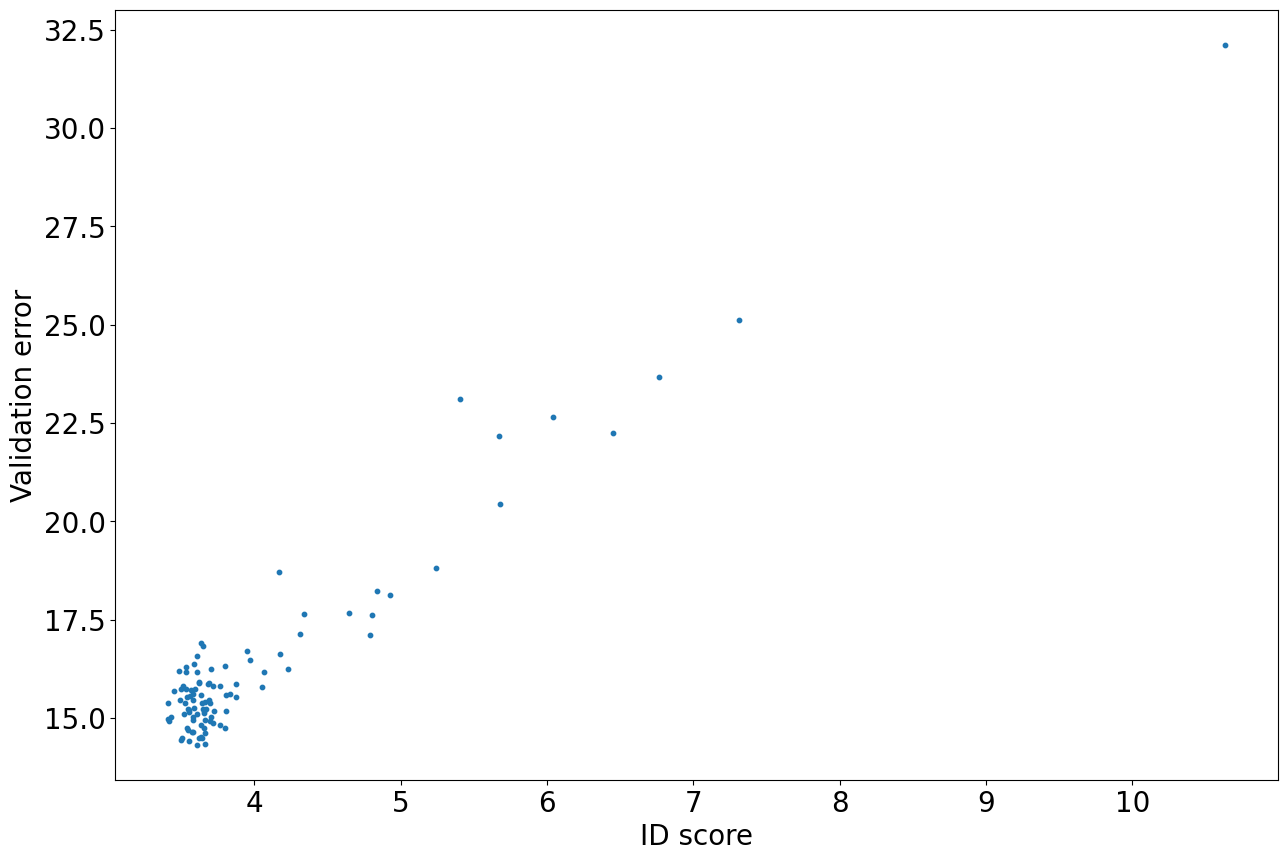

In [17]:
fig = plt.figure(dpi = 300)
plt.style.use("default")
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 20}) 
plt.scatter(y[1:],[(100-a) for a in validation_accuracy][1:], s = 10)
plt.xlabel("ID score")
plt.ylabel("Validation error")
plt.show()

In [57]:
import random


# Example usage
original_list = list(range(10000))
perturbed_list = perturb_list_by_swapping(original_list)


sum(int(a==b) for a,b in zip(original_list,perturbed_list))

9041

In [24]:
import random
a = np.array([np.array([1231])])
indices = random.sample(range(1),int(1))
indices
a[indices]

array([[1231]])

In [4]:
import torchvision as tv
print(tv.models.efficientnet_b0())

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat